# Instructions: 
1. For feature selections, run generate_train_test(*lag*, *weekly/monthly/daily*, *datasets used*) to generate training and testing dataset 
2. Uncomment .tocsv lines in the function to transform training and testing df to csv files.
3. Refer to last line of code for example

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# datasets chosen - tech companies
df_appl = pd.read_csv('../datasets/stocks/AAPL.csv')
df_ggl = pd.read_csv('../datasets/stocks/GOOGL.csv')
df_msft = pd.read_csv('../datasets/stocks/MSFT.csv')

Text(0, 0.5, 'Close Price')

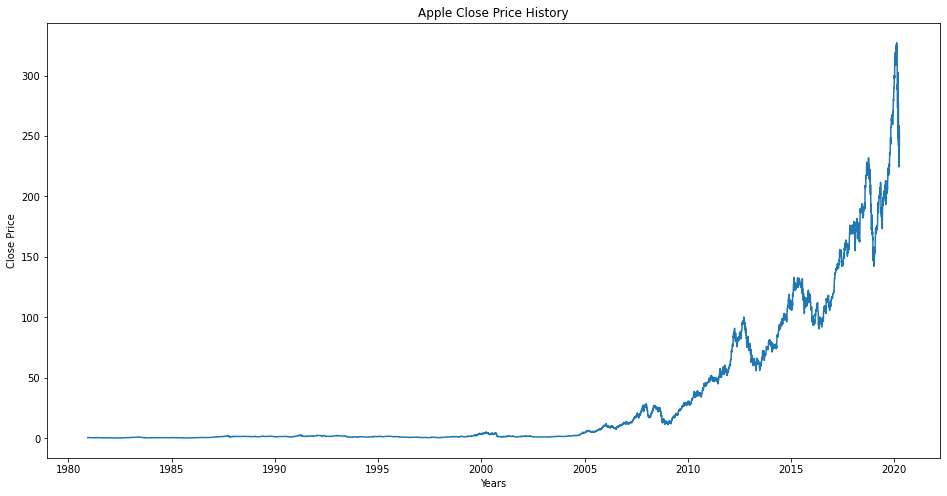

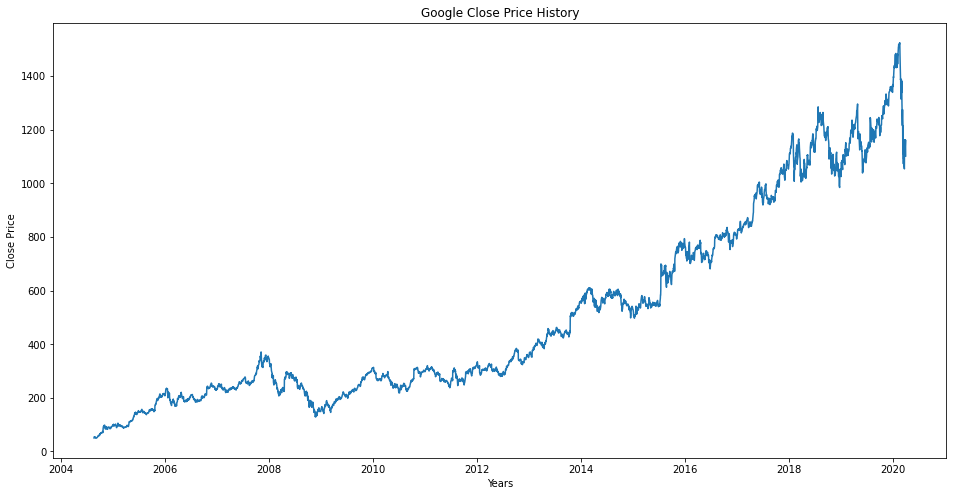

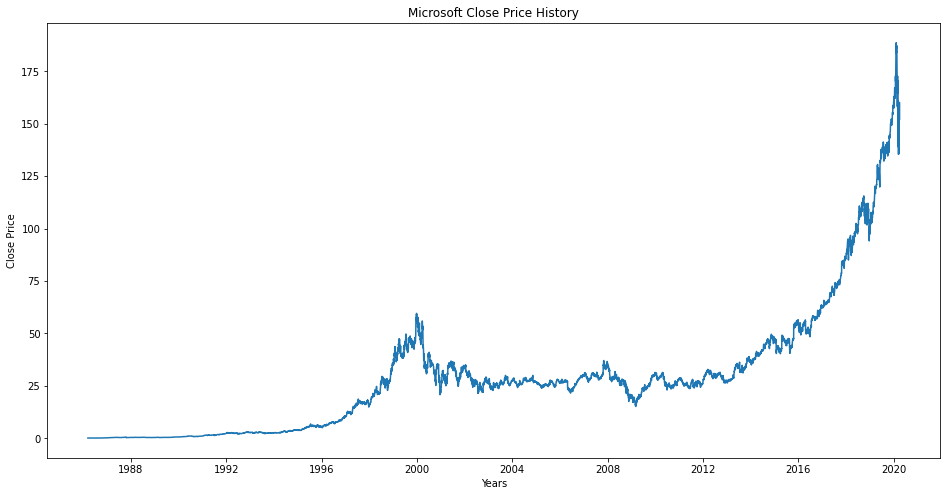

In [3]:
# apple
df_appl['Date'] = pd.to_datetime(df_appl.Date,format='%Y-%m-%d')
df_appl.index = df_appl['Date']
plt.figure(figsize=(16,8))
plt.plot(df_appl['Close'])
plt.title("Apple Close Price History")
plt.xlabel("Years")
plt.ylabel("Close Price")

# google
df_ggl['Date'] = pd.to_datetime(df_ggl.Date,format='%Y-%m-%d')
df_ggl.index = df_ggl['Date']
plt.figure(figsize=(16,8))
plt.plot(df_ggl['Close'])
plt.title("Google Close Price History")
plt.xlabel("Years")
plt.ylabel("Close Price")

# microsoft
df_msft['Date'] = pd.to_datetime(df_msft.Date,format='%Y-%m-%d')
df_msft.index = df_msft['Date']
plt.figure(figsize=(16,8))
plt.plot(df_msft['Close'])
plt.title("Microsoft Close Price History")
plt.xlabel("Years")
plt.ylabel("Close Price")

In [4]:
def split(df):
    train_size = round(len(df)*0.7)
    y_movement = df['movement']
    y_t = df['Close (t)']
    X_colnames = df.drop(['Close (t)', 'movement'], axis=1).columns
    X = df[X_colnames]

    # for movement
    X_train, X_test, y_train_movement, y_test_movement = X[:train_size], X[train_size:], y_movement[:train_size], y_movement[train_size:]

    # for t
    X_train, X_test, y_train_t, y_test_t = X[:train_size], X[train_size:], y_t[:train_size], y_t[train_size:]
    train_df = pd.concat([X_train,y_train_t,y_train_movement],axis = 1)
    test_df = pd.concat([X_test,y_test_t, y_test_movement],axis = 1)
    return train_df, test_df

In [5]:
def shift(df, n):
    new_df = pd.DataFrame()
    # volume
    vol = "Volume (t-"+str(n)+")"
    new_df[vol] = df['Volume']
    for i in range(n-1,0,-1):
        v = "Volume (t-"+str(i)+")"
        new_df[v] = df['Volume'].shift(-(n-i))

    # close price
    p = "Close (t-"+str(n)+")"
    new_df[p] = df['Close']
    for i in range(n-1,0,-1):
        v = "Close (t-"+str(i)+")"
        new_df[v] = df['Close'].shift(-(n-i))

    # y-variable (close price)
    new_df['Close (t)'] = df['Close'].shift(-n)
    new_df = new_df.dropna()

    # y-variable (movement)
    new_df['movement'] = np.where(new_df["Close (t)"] > new_df['Close (t-1)'], 1, 0)
    return new_df


In [6]:
# Automate pipeline to generate training and testing datasets based on lag
def generate_train_test(lag, avg = "weekly", *datasets):
    """
    Return the training and testing dataset, uncomment to transform df to csv after feature selections
    """
    train_all = pd.DataFrame()
    test_all = pd.DataFrame()
    for df in datasets:
        if avg == "weekly":
            df = df.resample('W').mean()
        elif avg == "monthly":
            df = df.resample('M').mean()
        #else, daily, noneed groupby
        df = shift(df, lag)
        train_df, test_df = split(df)
        train_all = pd.concat([train_all, train_df])
        test_all = pd.concat([test_all, test_df])
    #train_all.to_csv(str(lag)+"_"+avg+"_train.csv")
    #test_all.to_csv(str(lag)+"_"+avg+"_test.csv")
    return train_all, test_all


In [7]:
# Remove data where price stagnant
df_appl = df_appl[(df_appl['Date'] >= '2005-01-01')]
df_msft = df_msft[(df_msft['Date'] >= '1998-01-01')]

In [8]:
train_aapl, test_aapl = generate_train_test(10, "weekly", df_appl)
train_msft, test_msft = generate_train_test(10, "weekly", df_msft)
train_ggl, test_ggl = generate_train_test(10, "weekly", df_ggl)

In [ ]:
from sklearn.linear_model import LinearRegression
# 1 step Close only
model_aapl = LinearRegression()
x_train_aapl = train_aapl.drop('Close', axis=1)
y_train_aapl = train_aapl['Close']
model_aapl.fit(train_aapl, train_aapl)